Benjamin Linnik

# Logistic regression to solve the classification problem

![from C. Bishop "Pattern Recognition and Machine Learning" [Bis07]](Ex3Example.png)

Figure 4.12 from C. Bishop "Pattern Recognition and Machine Learning" [Bis07] gives a nice example of a case where a nonlinear transformation is very useful before applying logistic regression to solve the classification problem.

The original data space looks like the left picture. A non-linear set of gaussian basis functions transforms the red and blue dots into a space which is plotted in the right picture.

This transformation makes it possible to devide the data with a logistic regression model. The black line in both images shows the linear decision boundary in both spaces and devides both data sets correctly.



# What is the maximum likelihood solution for a (solved) logistic regression model

The maximum likelihood solution for a (solved) logistic regression model can be obtained by minimizing the cross entropy error function $E(\boldsymbol{w})$.

We set the derivative from exercise 1 to zero to find the minimizing solution:
$$
\sum_{n=1}^N (y_n - t_n) \boldsymbol{\phi}_n = \sum_{n=1}^N (\sigma(\boldsymbol{w}^T\boldsymbol{\phi}_n) - t_n) \boldsymbol{\phi}_n = 0
$$
This function will be zero, if all the $y_n $ are equal to all $t_n$ for every $n$.

$t_n$ can have the integer values:
$$
t_n \in \left\{0,1\right\}
$$


$y_n$ can have real values between 0 and 1:
$$
y_n \in \left[0,1\right]
$$

So, to have $y_n - t_n$ at zero for every $n$, $\sigma(\boldsymbol{w}^T\boldsymbol{\phi}_n)$ must be as close to 0 and 1 as possible, this can be achieved by making  the argument of the sigmodial $\boldsymbol{w}^T\boldsymbol{\phi}_n$ as large as possible, hence:

$$
\lim_{|\boldsymbol{w}|\rightarrow\pm\infty} \left( \sigma(\boldsymbol{w}^T\boldsymbol{\phi}_n) \right) =
\begin{cases} 
1 & |\boldsymbol{w}| \rightarrow \infty \\ 
0 & |\boldsymbol{w}| \rightarrow -\infty \\ 
\end{cases}
$$
For a large magnitude of $\boldsymbol{w}$ the error function of a correctly solved logistic regression model goes to zero, hereby maximizing the likelihood of the solution. 

q.e.d.

# Logistic Regression Hands-On

Generate two 2D data clouds and find best linear seperation use GradDesc to find best fitting values

For a detailed explanation see the comments, the proceeding was devided into five parts

In [1]:
import numpy as np # numerical lib
import numpy.ma as ma # masked arrays
import matplotlib.pyplot as plt # plot lib
%matplotlib inline

font = {'family' : 'serif',
        'weight'  : 'normal',
        'size'   : 16}

plt.rc('font', **font)

## part 1

In [2]:
# Generate the dataset
mu_1 = [1, 2] # 2-dimensional mean 1
mu_2 = [3, 3] # 2-dimensional mean 2
sigma_1 = [[0.5, 0.3], [0.3, 0.5]]  # covariance 1
sigma_2 = [[0.7, -0.3], [-0.3, 0.5]]  # covariance 2
num_pts = 100 # number of data points to sample for each distribution

np.random.seed(1) # make tests repeatable for performance studies
dist_N_1 = np.random.multivariate_normal(mu_1, sigma_1, num_pts)
dist_N_2 = np.random.multivariate_normal(mu_2, sigma_2, num_pts)

# combined distribution with label as third dimension
comb_dist_label = np.empty((0,3))
for point in range(num_pts):
    comb_dist_label = np.vstack([comb_dist_label,
                                 [dist_N_1[point,0], dist_N_1[point,1], 0]])
    comb_dist_label = np.vstack([comb_dist_label,
                                 [dist_N_2[point,0], dist_N_2[point,1], 1]])
#print(comb_dist_label)

## part 2

Preparation

In [3]:
# Use two linear basis functions and a bias for your feature vector.
def Basis_fct(x):
    return x # simply linear

def Get_phi(a_X):
    """
    Returns the vector of basis functions of size (3x1) for a feature vector v_x.
    Args:
        a_x (np.array): input features of size 1x2
    """
    # constuct vector phi_n
    a_phi = np.array([1, # bias
                      Basis_fct(a_X[0]),
                      Basis_fct(a_X[1])])

    return a_phi

def Get_Phi(m_X):
    """
    Returns the design matrix of size (Nx(M+1) for a feature vector v_x.

    Args:
        a_X (np.array): input features of size 1xN
    """
    # matrix with phi_n as rows, design matrix
    dimy = len(Get_phi(m_X[0]))
    m_Phi = np.empty((0,dimy))
    for row in range(len(m_X)):
        m_Phi = np.vstack([m_Phi, Get_phi(m_X[row])])
    return m_Phi

# cpnstruct label vector t function
def Get_t(m_X):
    a_t = np.array([])  
    for row in range(len(m_X)):
        a_t = np.append(a_t,m_X[row,2])  
    return a_t

def Transpose_array(vec):
    return vec.reshape(vec.shape + (1,))

def Sigmoid(x):  
    return 1 / (1 + np.exp(-x))

# y vector estimate
def Get_y(v_w, m_Phi):
    v_y = np.empty((0,1))
    for point in range(len(m_Phi)):
        v_y = np.vstack([v_y, Sigmoid(v_w.T.dot(Transpose_array(m_Phi[point,:])))])
    return v_y


Do what has to be done...

In [4]:
# construct label vector 
v_t = Transpose_array(Get_t(comb_dist_label))

# design matrix, each row is a transposed design vector
m_Phi = Get_Phi(comb_dist_label[:,0:2])

## part 3

In [5]:
def GradDesc(v_w, m_Phi, v_t, n, alpha, epsilon=10):
    count = 0
    for i in range(n):
        v_y = Get_y(v_w, m_Phi)
        gradE = np.array([0,0,0])
        for n in range(len(m_Phi)):
            gradE = gradE + (v_y[n]-v_t[n])*m_Phi[n,:]
        # don't do more iterations than necessary 
        if (np.linalg.norm(gradE)<epsilon):
            return v_w, count
        #print(np.linalg.norm(gradE))
        v_w = v_w - alpha*Transpose_array(gradE)
        count = count + 1
    return v_w, count

# calculate the x2 value, where the sigmoid gives 0.5 for given x1 values
def Get_Boundary(v_w, x1):
    y = (np.log(1)-v_w[0]-v_w[1]*x1)/v_w[2]
    return y

# Get prediction of class, everything >= 0.5 is in class 1, else in class 0
def Get_ClassPred(y_n):
    v_class = np.empty((0,1))
    for point in range(len(y_n)):
        if (y_n[point] >= 0.5):
            pred = 1
        else:
            pred = 0
        v_class = np.vstack([v_class, pred])
    return v_class    

## $\alpha=0.1$

In [6]:
# init w vector
v_w = Transpose_array(np.array([1,1,1]))
#v_w = Transpose_array(np.array([-65.58064473,18.73293133,10.06119078]))
# Do gradient descent
v_w, descent_count = GradDesc(v_w, m_Phi, v_t, 5000, 0.1, epsilon=10)
print("The weights estimated: bias, w_1, w_2")
print(v_w.view())

# calculate y vector with new weights
v_y = Get_y(v_w, m_Phi)
# Get labels for predicted classes
v_y_classpred = Get_ClassPred(v_y)
# find wrongly predicted classes rows
v_wrong_points = np.abs(v_y_classpred-v_t)

# construct new matrix, with comb_dist_label as the first three columns
# and the predicted class as the fourth column
comb_dist_label_pred = np.multiply(
    np.ones((len(comb_dist_label),4)),
    v_wrong_points)
comb_dist_label_pred[:,:-1] = comb_dist_label

# construct matrix with ONLY wrong predicted points
m_wrong_preddata = np.empty((0,4))
for point in range(len(comb_dist_label)):
    if v_wrong_points[point] == 1:
        m_wrong_preddata = np.vstack([m_wrong_preddata,
                                      comb_dist_label_pred[point,:]])
print("number of wrong predicted points: " + str(len(m_wrong_preddata)))
print("Accuracy: " + str(1-len(m_wrong_preddata)/len(m_Phi)))
print("Number of descents in GradDesc: " + str(descent_count) + " <------- !!!")


The weights estimated: bias, w_1, w_2
[[-53.59337163]
 [ 16.7096951 ]
 [  7.99959957]]
number of wrong predicted points: 6
Accuracy: 0.97
Number of descents in GradDesc: 73 <------- !!!


## part 4

Text(0,0.5,'y')

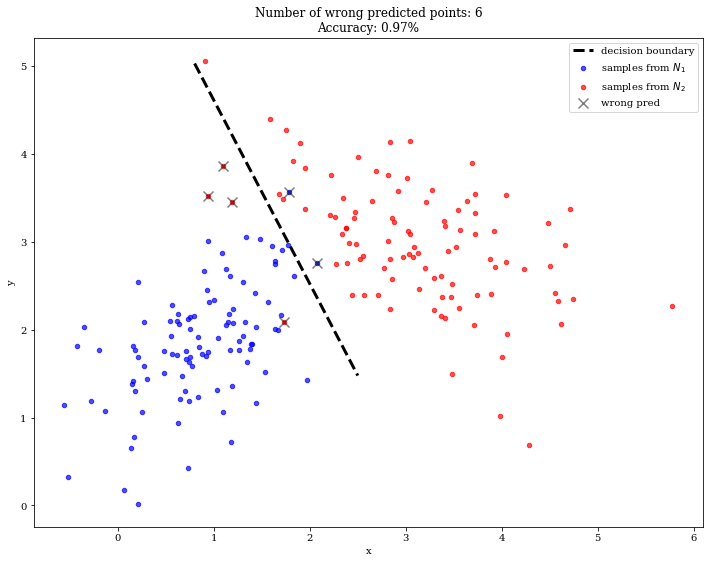

In [7]:
xplot = [0.8,2.5]
yplot = Get_Boundary(v_w,xplot)

fig, ax = plt.subplots(figsize=(12,9))  
ax.scatter(dist_N_1[:,0], dist_N_1[:,1], s=20, c='b', marker='o',
           label='samples from $N_1$', alpha=0.7)  
ax.scatter(dist_N_2[:,0], dist_N_2[:,1], s=20, c='r', marker='o',
           label='samples from $N_2$', alpha=0.7)  
ax.scatter(m_wrong_preddata[:,0], m_wrong_preddata[:,1], s=100, c='k', marker='x',
           label='wrong pred', alpha=0.5)  
ax.plot(xplot, yplot, 'k--', linewidth=3, label='decision boundary')
ax.legend()
ax.set_title("Number of wrong predicted points: " + str(len(m_wrong_preddata))+
             "\nAccuracy: " + str(1-len(m_wrong_preddata)/len(m_Phi)) + "%")
ax.set_xlabel('x') 
ax.set_ylabel('y') 
#ax.set_xlim(-2, 6)
#ax.set_ylim(-2, 6)

## Discussion 
As the two distribution overlap partially no clear seperation can be archieved. 

Nevertheless our linear regression could reach a ~96% accuracy which is quite nice. 

The $\alpha$ parameter is comparable to a learning rate. If chosen to small, more gradient descent steps are needed. The model is more "stiff". If chosen too big, the algorithm tends to jump over (misses) the lowest point in the multi dimensional parameter space and no good overall accuracy may be reached, but the descent will be faster.

### Just for fun a 'big' alpha
## $\alpha=100$

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp


number of wrong predicted points: 11
Accuracy: 0.945 <---- worse than with low alpha
Number of descents in GradDesc: 59 <---- better than with low alpha


Text(0,0.5,'y')

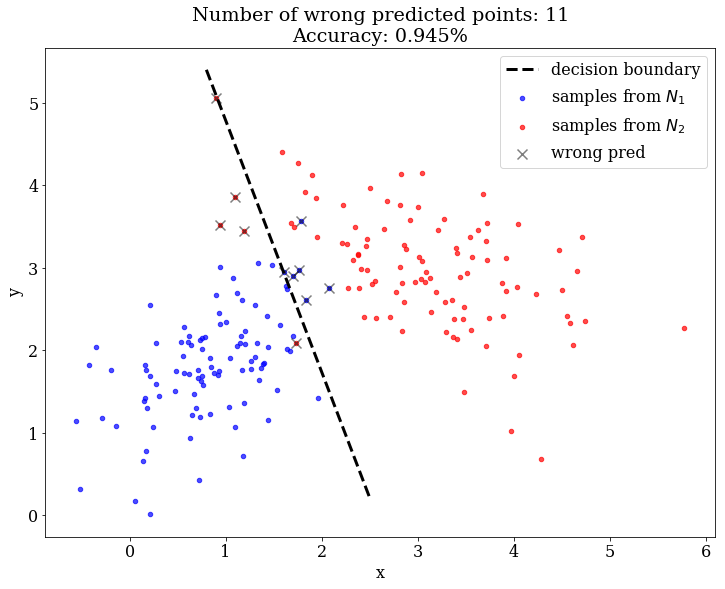

In [81]:
v_w = Transpose_array(np.array([1,1,1]))
v_w, descent_count = GradDesc(v_w, m_Phi, v_t, 1000, 100, epsilon=10)
v_y = Get_y(v_w, m_Phi)
v_y_classpred = Get_ClassPred(v_y)
v_wrong_points = np.abs(v_y_classpred-v_t)
comb_dist_label_pred = np.multiply(np.ones((len(comb_dist_label),4)), v_wrong_points)
comb_dist_label_pred[:,:-1] = comb_dist_label
m_wrong_preddata = np.empty((0,4))
for point in range(len(comb_dist_label)):
    if v_wrong_points[point] == 1:
        m_wrong_preddata = np.vstack([m_wrong_preddata, comb_dist_label_pred[point,:]])
print("number of wrong predicted points: " + str(len(m_wrong_preddata)))
print("Accuracy: " + str(1-len(m_wrong_preddata)/len(m_Phi)) + " <---- worse than with low alpha")
print("Number of descents in GradDesc: " + str(descent_count) + " <---- better than with low alpha")

xplot = [0.8,2.5]
yplot = Get_Boundary(v_w,xplot)
fig, ax = plt.subplots(figsize=(12,9)) 
ax.scatter(dist_N_1[:,0], dist_N_1[:,1], s=20, c='b', marker='o',
           label='samples from $N_1$', alpha=0.7)  
ax.scatter(dist_N_2[:,0], dist_N_2[:,1], s=20, c='r', marker='o',
           label='samples from $N_2$', alpha=0.7)  
ax.scatter(m_wrong_preddata[:,0], m_wrong_preddata[:,1], s=100, c='k', marker='x',
           label='wrong pred', alpha=0.5)  
ax.plot(xplot, yplot, 'k--', linewidth=3, label='decision boundary')
ax.legend()
ax.set_title("Number of wrong predicted points: " + str(len(m_wrong_preddata))
             +"\nAccuracy: " + str(1-len(m_wrong_preddata)/len(m_Phi)) + "%")
ax.set_xlabel('x') 
ax.set_ylabel('y') 
#ax.set_xlim(-2, 6)
#ax.set_ylim(-2, 6)

As expected, a bigger $\alpha$ leads to a faster descent, but also tends to be less accurate.

# References

[Bis07] Bishop, C. "Pattern Recognition and Machine Learning (Information Science and Statistics), 1st edn. 2006. corr. 2nd printing edn." Springer, New York (2007).